# Task 2: Baseline CNN

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD, RMSprop, lr_scheduler
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset

import shap

from data import get_img_dataset
from project3Lib.transforms import EnhanceContrast
import project3Lib.CNN as cnn
from masked_dataset import MaskedDataset
from pathlib import Path

/Users/noraschneider/opt/anaconda3/envs/BrainMRI/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [193]:
# load data and transform data if augmentation == yes
augmentation = input("Use augmentation? [yes/no]").lower() == "yes"

unique = input("Use unique images?[yes/no]").lower() == "yes"
input_path = "data/unique_images" if unique else "data/images"

if augmentation:
    transform = [EnhanceContrast(reduce_dim=False)]
    train_dataset,val_dataset, test_dataset = get_img_dataset(transform, data_path=input_path, use_same_transforms = True)
    transform = [EnhanceContrast(reduce_dim=False), transforms.RandomRotation(70), transforms.RandomHorizontalFlip(), transforms.ColorJitter()]
    train_dataset2,val_dataset2, _ = get_img_dataset(transform,data_path=input_path, use_same_transforms = True)
    train_dataset = ConcatDataset([train_dataset,train_dataset2, train_dataset2] )
    val_dataset = ConcatDataset([val_dataset,val_dataset2,val_dataset2])
    
    model_file_path = "baselineCNN_augmented_unique" if unique else "baselineCNN_augmented"
    
else: 
    train_dataset, val_dataset, test_dataset = get_img_dataset(data_path=input_path)
    
    model_file_path = "baselineCNN_unique" if unique else "baselineCNN"

model_file_path = "trained_weights/" + model_file_path
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)
batch_size = 16
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
print(f"Class sizes{np.unique([y for x,y in train_dataset], return_counts = True)}")

dataloaders = {
    'train' : trainloader, 
    'validation': validloader
}

image_datasets = {
    'train': train_dataset,
    'validation': val_dataset
}

Use augmentation? [yes/no]yes
Use unique images?[yes/no]yes
Loaded samples into dataset with label 'no'=0 and 'yes'=1
Loaded samples into dataset with label 'no'=0 and 'yes'=1
Device state: cpu
Class sizes(array([0, 1]), array([213, 261]))


In [3]:
def train_model(model, criterion, optimizer, dataloaders, image_datasets, patience = 0, num_epochs=3):
    last_loss = 200
    triggertimes = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
            # Early stopping
            if phase == 'train' or patience <= 0:
                continue
            
            if epoch_loss > last_loss:
                trigger_times += 1
                if trigger_times >= patience:
                    return best_model
            else:
                trigger_times = 0
                best_model = model

            last_loss = epoch_loss
            
    return best_model

def predict(model, x):
    model.eval()
    out = model(x.reshape(1, 3, 128, 128))   
    _,prediction = torch.max(out, dim=1)
    return prediction[0].item(), out

def test(model, test_dataset):
    x_test = [i for i,j in test_dataset]
    y_test = [j for i,j in test_dataset]
    preds = []
    outs = []
    for t in x_test:
        pred, out = predict(model, t)
        preds.append(pred)

    return accuracy_score(preds,y_test), f1_score(preds,y_test)

## Hyperparameters

In [7]:
# hyperparameters
parameters = {
    "lr": [0.001,0.0005,0.0001],
    "optimizers": ["SGD", "Adam", "RMSprop"]
}

results = {}

epochs = 50
for opt in parameters["optimizers"]:
    for lr in parameters["lr"]:
        model = cnn.BaselineClf()
        criterion = CrossEntropyLoss()

        if opt == "SGD":
            optimizer = SGD(model.parameters(), lr=lr)
        elif opt == "Adam":
            optimizer = Adam(model.parameters(), lr=lr)
        else:
            optimizer = RMSprop(model.parameters(), lr=lr)

        model = train_model(model, criterion, optimizer, dataloaders, image_datasets, 4, num_epochs=epochs)

        val_acc, val_f1 = test(model, val_dataset)

        results[f"{opt}_{lr}"] = (val_acc, val_f1)
        print(f"{opt}_{lr} - acc: {val_acc} - f1: {val_f1}")
    

Epoch 1/50
----------
train loss: 0.6905, acc: 0.5253
validation loss: 0.7351, acc: 0.4000
Epoch 2/50
----------
train loss: 0.6766, acc: 0.5738
validation loss: 0.6607, acc: 0.6833
Epoch 3/50
----------
train loss: 0.6492, acc: 0.6835
validation loss: 0.6759, acc: 0.5333
Epoch 4/50
----------
train loss: 0.6391, acc: 0.7004
validation loss: 0.6628, acc: 0.6000
Epoch 5/50
----------
train loss: 0.6260, acc: 0.7532
validation loss: 0.6416, acc: 0.7167
Epoch 6/50
----------
train loss: 0.6111, acc: 0.7764
validation loss: 0.6649, acc: 0.5833
Epoch 7/50
----------
train loss: 0.6100, acc: 0.7827
validation loss: 0.6626, acc: 0.6500
Epoch 8/50
----------
train loss: 0.5965, acc: 0.7996
validation loss: 0.6395, acc: 0.7000
Epoch 9/50
----------
train loss: 0.5807, acc: 0.8122
validation loss: 0.6401, acc: 0.7000
Epoch 10/50
----------
train loss: 0.5786, acc: 0.8101
validation loss: 0.6313, acc: 0.7000
Epoch 11/50
----------
train loss: 0.5735, acc: 0.8186
validation loss: 0.6366, acc: 0.65

validation loss: 0.6120, acc: 0.7167
Epoch 42/50
----------
train loss: 0.5204, acc: 0.8228
validation loss: 0.6097, acc: 0.7167
Epoch 43/50
----------
train loss: 0.5158, acc: 0.8418
validation loss: 0.6141, acc: 0.7167
Epoch 44/50
----------
train loss: 0.5200, acc: 0.8460
validation loss: 0.6089, acc: 0.7167
Epoch 45/50
----------
train loss: 0.5090, acc: 0.8502
validation loss: 0.6225, acc: 0.7167
Epoch 46/50
----------
train loss: 0.5114, acc: 0.8502
validation loss: 0.6141, acc: 0.7167
Epoch 47/50
----------
train loss: 0.5088, acc: 0.8565
validation loss: 0.6029, acc: 0.7333
Epoch 48/50
----------
train loss: 0.5105, acc: 0.8502
validation loss: 0.6240, acc: 0.7333
Epoch 49/50
----------
train loss: 0.5074, acc: 0.8460
validation loss: 0.5849, acc: 0.7333
Epoch 50/50
----------
train loss: 0.5126, acc: 0.8312
validation loss: 0.6244, acc: 0.7167
SGD_0.0005 - acc: 0.6666666666666666 - f1: 0.7560975609756099
Epoch 1/50
----------
train loss: 0.7044, acc: 0.4684
validation loss: 0.

validation loss: 0.7439, acc: 0.5833
Epoch 30/50
----------
train loss: 0.4051, acc: 0.9093
validation loss: 0.6240, acc: 0.6833
Epoch 31/50
----------
train loss: 0.3861, acc: 0.9262
validation loss: 0.5895, acc: 0.7000
Epoch 32/50
----------
train loss: 0.3823, acc: 0.9283
validation loss: 0.8497, acc: 0.4333
Epoch 33/50
----------
train loss: 0.3837, acc: 0.9241
validation loss: 0.6791, acc: 0.6167
Epoch 34/50
----------
train loss: 0.3872, acc: 0.9219
validation loss: 0.8168, acc: 0.5000
Epoch 35/50
----------
train loss: 0.4003, acc: 0.9135
validation loss: 0.6337, acc: 0.6500
Epoch 36/50
----------
train loss: 0.3784, acc: 0.9325
validation loss: 0.6068, acc: 0.7000
Epoch 37/50
----------
train loss: 0.3976, acc: 0.9051
validation loss: 0.6826, acc: 0.6000
Epoch 38/50
----------
train loss: 0.3756, acc: 0.9388
validation loss: 0.6757, acc: 0.6333
Epoch 39/50
----------
train loss: 0.3946, acc: 0.9198
validation loss: 0.7172, acc: 0.5667
Epoch 40/50
----------
train loss: 0.3923, 

train loss: 0.4896, acc: 0.8143
validation loss: 0.5845, acc: 0.7500
Epoch 4/50
----------
train loss: 0.4696, acc: 0.8439
validation loss: 0.5150, acc: 0.7833
Epoch 5/50
----------
train loss: 0.4707, acc: 0.8291
validation loss: 0.5462, acc: 0.7667
Epoch 6/50
----------
train loss: 0.4686, acc: 0.8460
validation loss: 0.6824, acc: 0.6333
Epoch 7/50
----------
train loss: 0.4579, acc: 0.8586
validation loss: 0.5642, acc: 0.7333
Epoch 8/50
----------
train loss: 0.4494, acc: 0.8629
validation loss: 0.6019, acc: 0.7000
Epoch 9/50
----------
train loss: 0.4340, acc: 0.8776
validation loss: 0.6708, acc: 0.6167
Epoch 10/50
----------
train loss: 0.4140, acc: 0.9008
validation loss: 0.6745, acc: 0.6000
Epoch 11/50
----------
train loss: 0.4181, acc: 0.8945
validation loss: 0.5553, acc: 0.7667
Epoch 12/50
----------
train loss: 0.4320, acc: 0.8734
validation loss: 0.5737, acc: 0.7333
Epoch 13/50
----------
train loss: 0.4526, acc: 0.8502
validation loss: 0.8733, acc: 0.4167
Epoch 14/50
-----

train loss: 0.3666, acc: 0.9430
validation loss: 0.6912, acc: 0.5833
Epoch 43/50
----------
train loss: 0.3704, acc: 0.9430
validation loss: 0.6273, acc: 0.6667
Epoch 44/50
----------
train loss: 0.3783, acc: 0.9367
validation loss: 0.8390, acc: 0.4667
Epoch 45/50
----------
train loss: 0.3664, acc: 0.9473
validation loss: 0.6343, acc: 0.6833
Epoch 46/50
----------
train loss: 0.3636, acc: 0.9515
validation loss: 0.7016, acc: 0.6167
Epoch 47/50
----------
train loss: 0.3592, acc: 0.9557
validation loss: 0.6763, acc: 0.6333
Epoch 48/50
----------
train loss: 0.3403, acc: 0.9705
validation loss: 0.6552, acc: 0.6500
Epoch 49/50
----------
train loss: 0.3729, acc: 0.9367
validation loss: 0.6393, acc: 0.6667
Epoch 50/50
----------
train loss: 0.3712, acc: 0.9473
validation loss: 0.7592, acc: 0.5500
RMSprop_0.0005 - acc: 0.5166666666666667 - f1: 0.5084745762711865
Epoch 1/50
----------
train loss: 0.5778, acc: 0.7068
validation loss: 0.6834, acc: 0.6000
Epoch 2/50
----------
train loss: 0.50

Optimal hyperparameters for **unique dataset (no augmentation)**: 
```
{'SGD_0.001': (0.4, 0.3333333333333333),
 'SGD_0.0005': (0.7, 0.7692307692307692),
 'SGD_0.0001': (0.65, 0.7741935483870968),
 'Adam_0.001': (0.65, 0.7199999999999999),
 'Adam_0.0005': (0.7, 0.7692307692307692),
 'Adam_0.0001': (0.65, 0.7407407407407408),
 'RMSprop_0.001': (0.75, 0.8148148148148148),
 'RMSprop_0.0005': (0.7, 0.7692307692307692),
 'RMSprop_0.0001': (0.6, 0.6923076923076924)}
```
 
 
Optimal hyperparameters for **augmented dataset**:
 
```
{'SGD_0.001': (0.7333333333333333, 0.7999999999999999),
 'SGD_0.0005': (0.6666666666666666, 0.7560975609756099),
 'SGD_0.0001': (0.7166666666666667, 0.7848101265822784),
 'Adam_0.001': (0.6166666666666667, 0.7578947368421053),
 'Adam_0.0005': (0.5666666666666667, 0.5937499999999999),
 'Adam_0.0001': (0.6666666666666666, 0.7435897435897436),
 'RMSprop_0.001': (0.6833333333333333, 0.7164179104477612),
 'RMSprop_0.0005': (0.5166666666666667, 0.5084745762711865),
 'RMSprop_0.0001': (0.65, 0.7272727272727273)}
```

In [12]:
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

1,606,802 training parameters.


# Train final model

In [199]:
n = 20
accs = []
f1s = []
for i in range(n):
    model = cnn.BaselineClf()
    criterion = CrossEntropyLoss()
    if augmentation:
        optimizer = SGD(model.parameters(), lr=0.001)
    else:
        optimizer = RMSprop(model.parameters(), lr=0.001)
    epochs = 50
    model = train_model(model, criterion, optimizer, dataloaders, image_datasets, 4, num_epochs=epochs)
    acc, f1 = test(model, test_dataset)
    accs.append(acc)
    f1s.append(f1)

Epoch 1/50
----------
train loss: 0.6836, acc: 0.5717
validation loss: 0.6796, acc: 0.6000
Epoch 2/50
----------
train loss: 0.6661, acc: 0.6371
validation loss: 0.6671, acc: 0.6333
Epoch 3/50
----------
train loss: 0.6494, acc: 0.6540
validation loss: 0.6849, acc: 0.6333
Epoch 4/50
----------
train loss: 0.6315, acc: 0.6983
validation loss: 0.6827, acc: 0.5333
Epoch 5/50
----------
train loss: 0.6164, acc: 0.7173
validation loss: 0.6654, acc: 0.5500
Epoch 6/50
----------
train loss: 0.6000, acc: 0.7658
validation loss: 0.6655, acc: 0.6500
Epoch 7/50
----------
train loss: 0.5876, acc: 0.7764
validation loss: 0.6604, acc: 0.6500
Epoch 8/50
----------
train loss: 0.5813, acc: 0.7785
validation loss: 0.6603, acc: 0.6667
Epoch 9/50
----------
train loss: 0.5762, acc: 0.7869
validation loss: 0.6350, acc: 0.6333
Epoch 10/50
----------
train loss: 0.5630, acc: 0.8228
validation loss: 0.6459, acc: 0.6667
Epoch 11/50
----------
train loss: 0.5612, acc: 0.8017
validation loss: 0.6267, acc: 0.68

In [202]:
torch.save(model.state_dict(), f"{model_file_path}.pt")

In [200]:
a, f = test(model, test_dataset)
print(f"Accuracy mean: {np.mean(accs)} std: {np.std(accs)}")
print(f"F1 mean: {np.mean(f1s)} std: {np.std(f1s)}")
print(f"Score of saved model: acc = {a} and f1 = {f}")

Accuracy mean: 0.75 std: 0.0
F1 mean: 0.761904761904762 std: 0.0
Score of saved model: acc = 0.75 and f1 = 0.761904761904762


Using unique images according to our filtering method, resulted in our CNN Baseline not converging. Trying out different learning rates, optimizers, early stopping patience and max number of epochs can not solve this issue. To demonstrate this, we report the mean performance scores and their variances from training the baseline model 20 times. The following results can be observed for using **no augmentation**: 

```
    In 20 runs: 
    Accuracy mean: 0.7049999999999998 std: 0.09733961166965893
    F1 mean: 0.706971187025535 std: 0.12677314667331263
```

with **augmentation**: 

```
    In 20 runs: 
    Accuracy mean: 0.7250000000000001 std: 0.07500000000000001
    F1 mean: 0.7149891216454686 std: 0.0951993497268051
```

we suspect, that the baseline CNN has too many parameters (in total 1,606,802 parameters). 

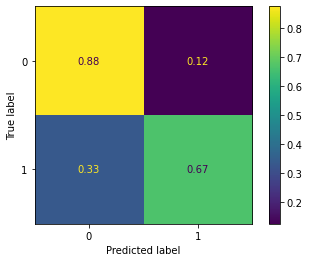

In [201]:
x_test = [i for i,j in test_dataset]
y_test = [j for i,j in test_dataset]
preds = []
outs = []
for t in x_test:
    pred, out = predict(model, t)
    preds.append(pred)
    
cm=confusion_matrix(y_test,preds,normalize="true")
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

**No augmentation model** with accuracy = 0.75 and f1 = 0.7826086956521738

![](Plots/CM_Baseline_Unique_NoAugmentation.png)

**Augmentation model** with acc = 0.75 and f1 = 0.761904761904762

## SHAP analysis

Since the baselinemodel does not converge, we conduct the SHAP analysis for one instance of the trained models.

In [194]:
model = cnn.BaselineClf()
model.load_state_dict(torch.load(f"{model_file_path}.pt"))
model.eval()

BaselineClf(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Re

Mean values 0.4796051237936513, 0.5203948769136824
Image #0: True Class 1, Prediction 1, Probabilities tensor([[0.1134, 0.8866]], grad_fn=<SoftmaxBackward0>)


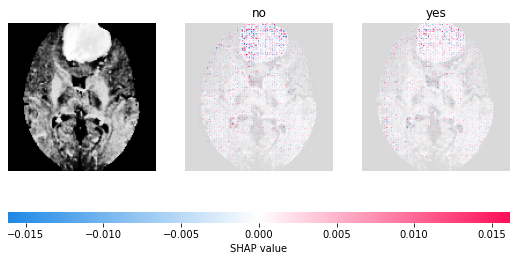

Image #1: True Class 0, Prediction 0, Probabilities tensor([[0.8572, 0.1428]], grad_fn=<SoftmaxBackward0>)


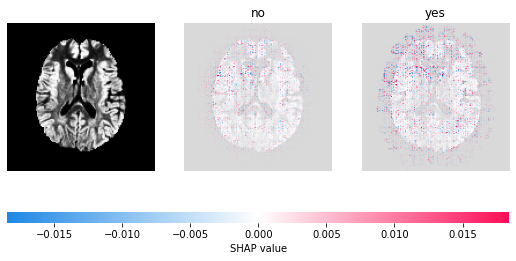

Image #2: True Class 1, Prediction 0, Probabilities tensor([[0.8016, 0.1984]], grad_fn=<SoftmaxBackward0>)


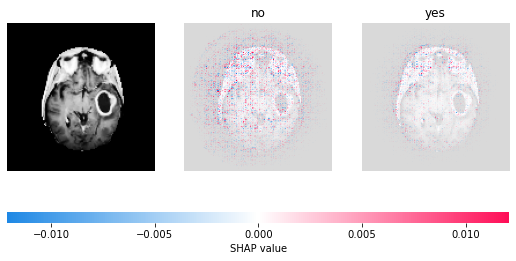

Image #3: True Class 1, Prediction 0, Probabilities tensor([[0.6781, 0.3219]], grad_fn=<SoftmaxBackward0>)


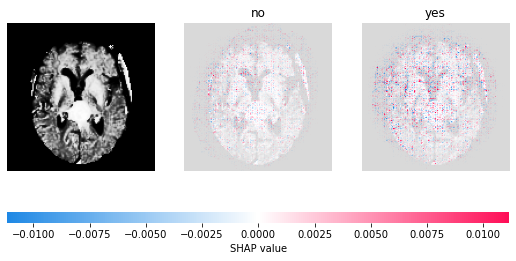

Image #4: True Class 0, Prediction 0, Probabilities tensor([[0.6883, 0.3117]], grad_fn=<SoftmaxBackward0>)


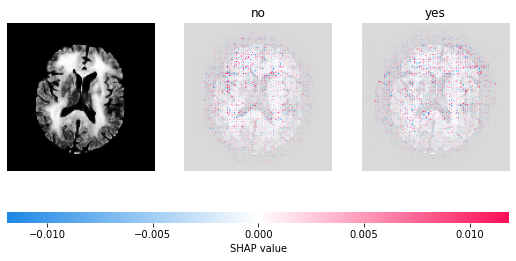

Image #5: True Class 1, Prediction 0, Probabilities tensor([[0.7493, 0.2507]], grad_fn=<SoftmaxBackward0>)


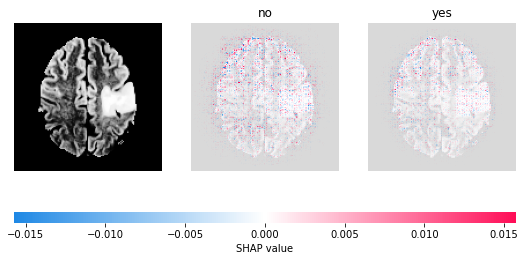

Image #6: True Class 1, Prediction 1, Probabilities tensor([[0.2006, 0.7994]], grad_fn=<SoftmaxBackward0>)


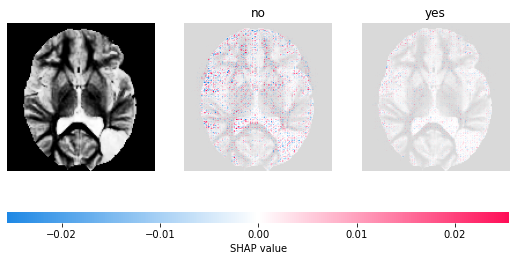

Image #7: True Class 1, Prediction 1, Probabilities tensor([[0.3632, 0.6368]], grad_fn=<SoftmaxBackward0>)


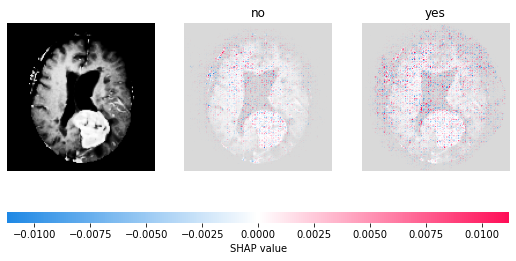

Image #8: True Class 1, Prediction 0, Probabilities tensor([[0.9462, 0.0538]], grad_fn=<SoftmaxBackward0>)


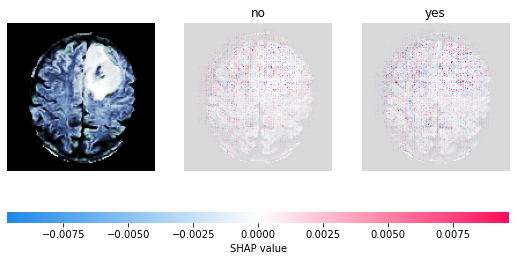

Image #9: True Class 1, Prediction 1, Probabilities tensor([[0.2217, 0.7783]], grad_fn=<SoftmaxBackward0>)


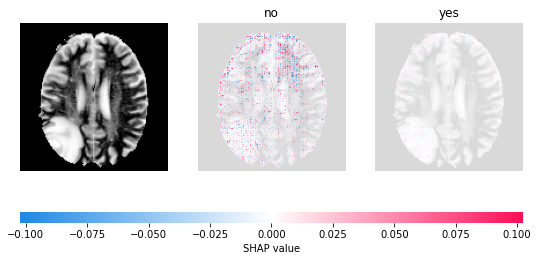

Image #10: True Class 1, Prediction 1, Probabilities tensor([[0.1539, 0.8461]], grad_fn=<SoftmaxBackward0>)


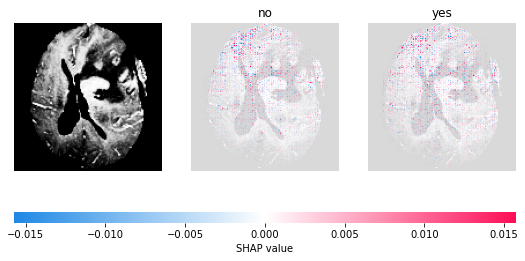

Image #11: True Class 0, Prediction 0, Probabilities tensor([[0.6206, 0.3794]], grad_fn=<SoftmaxBackward0>)


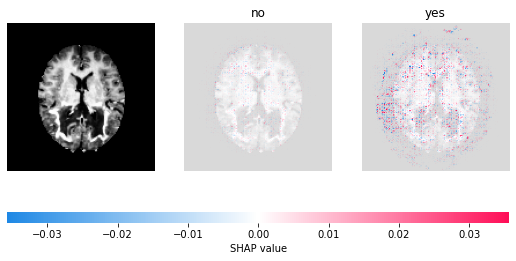

Image #12: True Class 0, Prediction 0, Probabilities tensor([[0.5575, 0.4425]], grad_fn=<SoftmaxBackward0>)


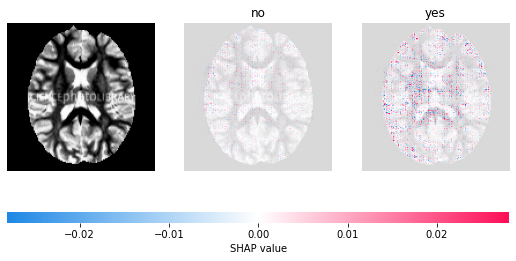

Image #13: True Class 1, Prediction 1, Probabilities tensor([[0.1394, 0.8606]], grad_fn=<SoftmaxBackward0>)


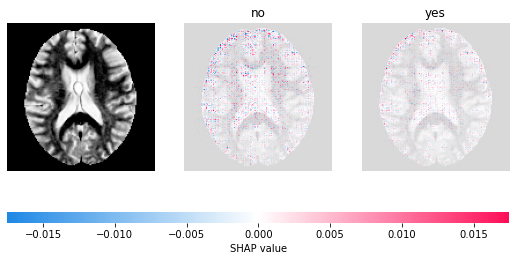

Image #14: True Class 1, Prediction 1, Probabilities tensor([[0.4037, 0.5963]], grad_fn=<SoftmaxBackward0>)


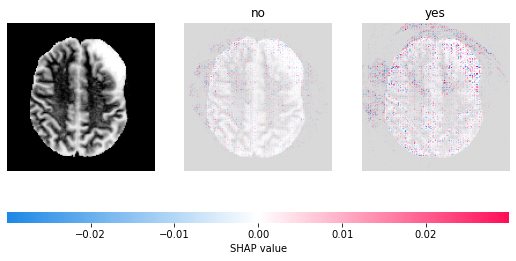

Image #15: True Class 0, Prediction 0, Probabilities tensor([[0.8249, 0.1751]], grad_fn=<SoftmaxBackward0>)


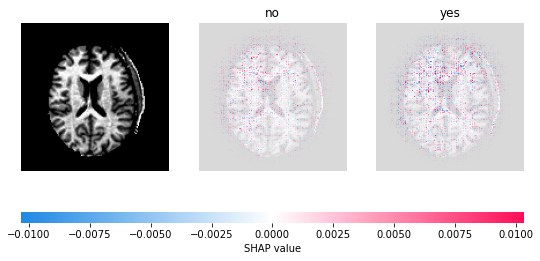

Image #16: True Class 1, Prediction 1, Probabilities tensor([[0.4634, 0.5366]], grad_fn=<SoftmaxBackward0>)


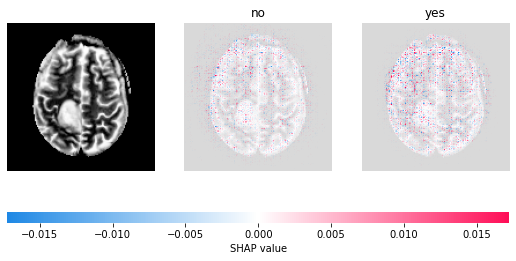

Image #17: True Class 0, Prediction 0, Probabilities tensor([[0.6688, 0.3312]], grad_fn=<SoftmaxBackward0>)


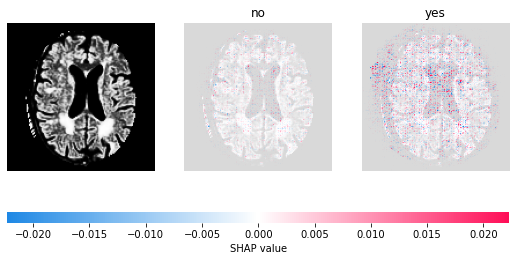

Image #18: True Class 0, Prediction 0, Probabilities tensor([[0.6908, 0.3092]], grad_fn=<SoftmaxBackward0>)


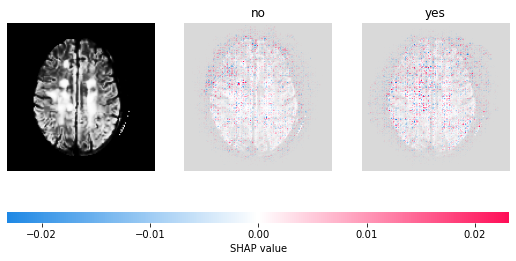

Image #19: True Class 0, Prediction 0, Probabilities tensor([[0.8758, 0.1242]], grad_fn=<SoftmaxBackward0>)


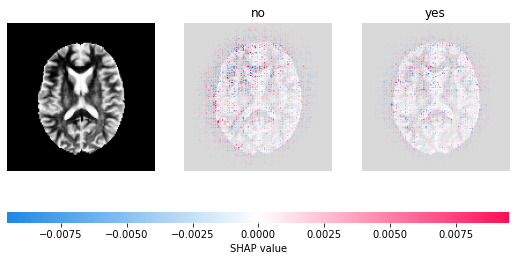

In [195]:
# Deep Explainer
bg = [i for i,j in train_dataset]
bg = torch.stack(bg)
e = shap.DeepExplainer(model, bg)

outs = []
for i in bg:
    pred, out = predict(model,i)
    outs.append((out[0][0].item(), out[0][1].item()))
print(f"Mean values {np.mean([i for i,j in outs])}, {np.mean([j for i,j in outs])}")

test_images = [i for i,j in test_dataset]
y_test = [j for i,j in test_dataset]

for i, image in enumerate(test_images):
    
    image = image.reshape((1,3,128,128))
    pred, out = predict(model,image)
    shap_values = e.shap_values(image)
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(image.cpu().numpy(), 1, -1), 1, 2)
    print(f"Image #{i}: True Class {y_test[i]}, Prediction {pred}, Probabilities {out}")
    shap.image_plot(shap_numpy, test_numpy, labels = ["no","yes"])

# Compare tumor images with manual segmentation

In [308]:
if augmentation:
    transform = [EnhanceContrast(reduce_dim=False)]
    _,_, test_dataset = get_img_dataset(common_transforms=transform, \
                                        data_path=input_path, \
                                        folder_type = MaskedDataset, \
                                        mask_folder=Path("data/masks"))
else: 
    _, _, test_dataset = get_img_dataset(data_path=input_path, folder_type = MaskedDataset, mask_folder=Path("data/masks"))

Loaded samples into dataset with label 'no'=0 and 'yes'=1


In [309]:
# Deep Explainer
bg = [i.reshape(3,128,128) for i,_ in train_dataset]
bg = torch.stack(bg)
e = shap.DeepExplainer(model, bg)

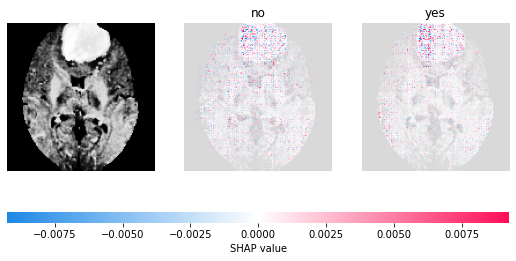

In [303]:
index = 0
image = test_dataset[index][0].reshape((1,3,128,128))
shap_values = e.shap_values(image)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(image.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, test_numpy, labels = ["no","yes"])

In [307]:
a = np.copy(shap_values[1].reshape(3,128,128))
mask = test_dataset[index][1].numpy().reshape((128,128))
mask = np.stack([mask,mask,mask])
evaluate_interpretability(a,mask,0.05)

0.19143027177147393

In [287]:
threshold

1.5794737919350155e-05

In [293]:
np.unique(mask, return_counts = True)

(array([0., 1.], dtype=float32), array([42246,  6906]))